# Final competition of Deep Learning 2020 Spring
Traffic environment semi-supervised Learning Contest

## Goals
The objective is to train a model using images captured by six different cameras attached to the same car to generate a top down view of the surrounding area. The performance of the model will be evaluated by (1) the ability of detecting objects (like car, trucks, bicycles, etc.) and (2) the ability to draw the road map layout.

## Data
You will be given two sets of data:

 1. Unlabeled set: just images
 2. Labeled set: images and the labels(bounding box and road map layout)

This notebook will help you understand the dataset.

In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

# Dataset

You will get two different datasets:

 1. an unlabeled dataset for pre-training
 2. a labeled dataset for both training and validation
 
## The dataset is organized into three levels: scene, sample and image

 1. A scene is 25 seconds of a car's journey.
 2. A sample is a snapshot of a scene at a given timeframe. Each scene will be divided into 126 samples, so about 0.2 seconds between consecutive samples.
 3. Each sample contains 6 images captured by camera facing different orientation.
    Each camera will capture 70 degree view. To make it simple, you can safely assume that the angle between the cameras is 60 degrees 

106 scenes in the unlabeled dataset and 28 scenes in the labeled dataset

In [4]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

# Labeled dataset

In [5]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
transform = torchvision.transforms.ToTensor()
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=5, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [6]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([5, 6, 3, 256, 306])


There are two kind of labels

 1. The bounding box of surrounding objects
 2. The binary road_image

# Visualize the bounding box

In [7]:
def draw_box_mod(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 2], corners[:, 1], corners[:, 3], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)

In [16]:
result[0]

(tensor([[[-1.9414e+00,  7.6073e+00, -1.9414e+00,  7.6073e+00],
          [ 2.8882e+01,  2.4248e+01,  2.4248e+01,  2.8882e+01]],
 
         [[-7.4156e+00,  1.0331e+00, -7.4156e+00,  1.0331e+00],
          [ 2.7549e+01,  2.5310e+01,  2.5310e+01,  2.7549e+01]],
 
         [[-1.0629e+01, -6.4480e+00, -1.0629e+01, -6.4480e+00],
          [ 1.4161e+01,  1.2293e+01,  1.2293e+01,  1.4161e+01]],
 
         [[-5.5452e+00, -2.5579e-01, -5.5452e+00, -2.5579e-01],
          [ 1.7259e+01,  1.4516e+01,  1.4516e+01,  1.7259e+01]],
 
         [[ 1.5649e+01,  1.9698e+01,  1.5649e+01,  1.9698e+01],
          [ 8.4782e+00,  6.9284e+00,  6.9284e+00,  8.4782e+00]],
 
         [[ 1.4533e+01,  1.9051e+01,  1.4533e+01,  1.9051e+01],
          [ 2.7787e+01,  2.5506e+01,  2.5506e+01,  2.7787e+01]],
 
         [[ 9.1832e+00,  1.3141e+01,  9.1832e+00,  1.3141e+01],
          [ 4.2619e+00,  2.8469e+00,  2.8469e+00,  4.2619e+00]],
 
         [[-1.4001e+01, -7.8329e+00, -1.4001e+01, -7.8329e+00],
          [ 1.3888e

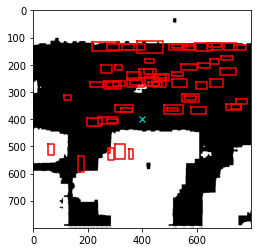

In [11]:
from src import *

model = KobeModel(num_classes = 10,
                               encoder_features = 6,
                               rm_dim = 800,
                 prob_thresh=0.1,
                 conf_thresh=0.1,
                 nms_thresh=0.7,
                 )
        
model.load_state_dict(torch.load('F:/dl-project/kobe_model_s16_288_lr3_4_5_epochs.pt', map_location='cpu'))


sample_n = 0

with torch.no_grad():

    result = model.get_bounding_boxes(sample[sample_n].view(1, 6, 3, 256, 306))

    roadmap_result = model.get_road_map(sample[sample_n].view(1, 6, 3, 256, 306))

from helper import *

best_ts = 0
best_n = 0

for n in range(100):
    ts = compute_ts_road_map(roadmap_result[0] > n/100, road_image[0])
    if ts > best_ts:
        best_ts = ts
        best_n = n
#print('raw:')
#print(compute_ts_road_map(roadmap_result[0], road_image[0]))
#print(f'best: {best_n}, {best_ts}')

#print(model)

reordered_result = result[0][0][:, :, [0, 2, 3, 1]]

ats_bounding_boxes, iou_max = compute_ats_bounding_boxes(result[0][0], target[0]['bounding_box'])
#print(ats_bounding_boxes)
#print(iou_max)

ats_bounding_boxes, iou_max = compute_ats_bounding_boxes(reordered_result, target[0]['bounding_box'])
#print(ats_bounding_boxes)
#print(iou_max)
#print(pred_decode.__str__())

# The center of image is 400 * 400

fig, ax = plt.subplots()

#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(roadmap_result[0].detach()[0] > 0.53, cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="cyan")

reordered_result = result[0][0][:, :, [0, 2, 3, 1]]

for i, bb in enumerate(reordered_result):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color='red')
    pass

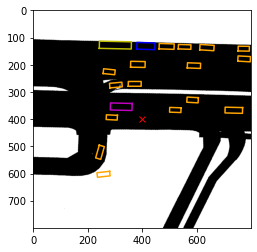

In [9]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[sample_n]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[sample_n]['category'][i]])    